<a href="https://colab.research.google.com/github/tahaadams/mdat/blob/main/Practicum_3_Model_Development_and_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 10)

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_style('darkgrid')

from scipy import stats

from sklearn.datasets import load_iris

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

import calendar

# Question 1 — The DS Problem (0 point)
In your own words, formulate the Data Science problem.

In this dataset, we attempt to analyze the relationship between lifestyle and diabetic outcomes for patients in the USA by analyzing trends in features like age, location, race, and other social determinants of health.

# Question 2 — Prepare the Data (5 pts) - Emily
Evaluate the dataset to determine if ALL variables are represented in their expected type. Convert variables to suitable data types for ML modeling. This means that you need to identify categorical data, discrete and continuous variables represent them accordingly.
Analyze the data to determine what preprocessing steps are needed to ensure that the following are handled: 1) missing values, 2) invalid values, 3) outliers. Perform the required data preparation steps and justify the approach that is taken to prepare the data for analysis.

In [ ]:
# 2
# Loads the dataset
file_path = 'diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_data = pd.read_csv(file_path)

# sets the continuous versus categorical columns
cat_col = ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke','HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump','AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'Education', 'Income']
contin_col = ['BMI', 'MentHlth', 'PhysHlth', 'GenHlth']

# drops missing vals
data = diabetes_data.dropna(axis=1)


# checks to see if we need to delete invalid values, such as out of range vals
for col in cat_col:
    if col in data.columns:
        print(f"{col}: {diabetes_data[col].unique()}")


# gets rid of outliers
for col in contin_col:
    if col in data.columns:
        Q1 = diabetes_data[col].quantile(0.25)
        Q3 = diabetes_data[col].quantile(0.75)
        Interqr = Q3 - Q1
        lower_bound = Q1 - 1.5 * Interqr
        upper_bound = Q3 + 1.5 * Interqr
        diabetes_data[col] = diabetes_data[col].clip(lower_bound, upper_bound)


# Saves new data
diabetes_data.to_csv(file_path, index=False)

Diabetes_012: [0. 2. 1.]
HighBP: [1. 0.]
HighChol: [1. 0.]
CholCheck: [1. 0.]
Smoker: [1. 0.]
Stroke: [0. 1.]
HeartDiseaseorAttack: [0. 1.]
PhysActivity: [0. 1.]
Fruits: [0. 1.]
Veggies: [1. 0.]
HvyAlcoholConsump: [0. 1.]
AnyHealthcare: [1. 0.]
NoDocbcCost: [0. 1.]
DiffWalk: [1. 0.]
Sex: [0. 1.]
Education: [4. 6. 3. 5. 2. 1.]
Income: [3. 1. 8. 6. 4. 7. 2. 5.]


# Question 3 — (20 points) - Emily
Perform exploratory data analysis. Ensure that you analyze the relationships between the various features and social determinants of health in the dataset, and the diabetic outcomes. Create visualizations to demonstrate your findings and explain the results.

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


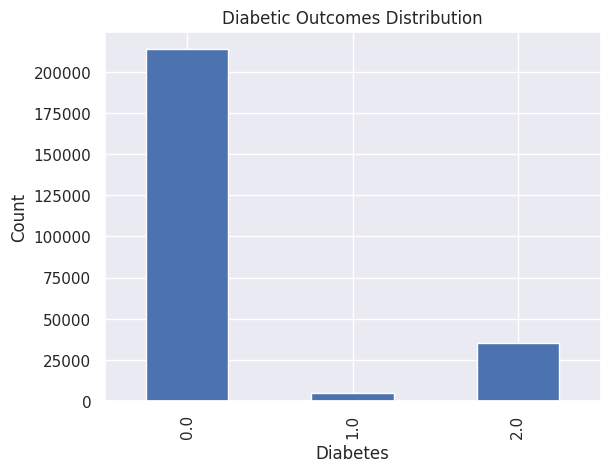

In [ ]:
# 3.1

# looking at distribution & plotting
print(diabetes_data['Diabetes_012'].value_counts())

# Plotting the distribution
diabetes_data['Diabetes_012'].value_counts().sort_index().plot(kind='bar')
plt.title('Diabetic Outcomes Distribution')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()



This graph looks at the data to see the scope of how many individuals are diabetic (2), prediabetic (1), or do not have diabetes (0). As shown, the majority of the individuals in the dataset do not have a diabetes diagnosis.

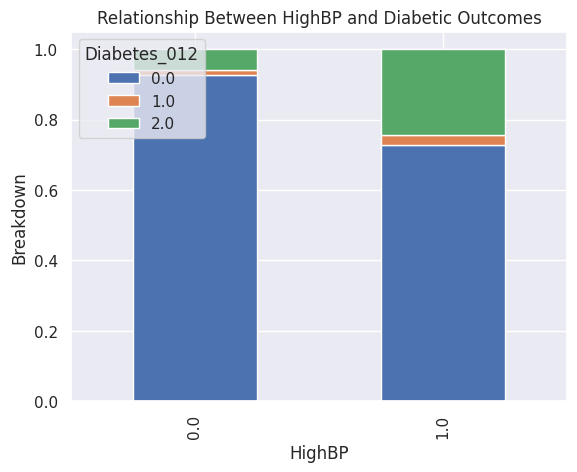

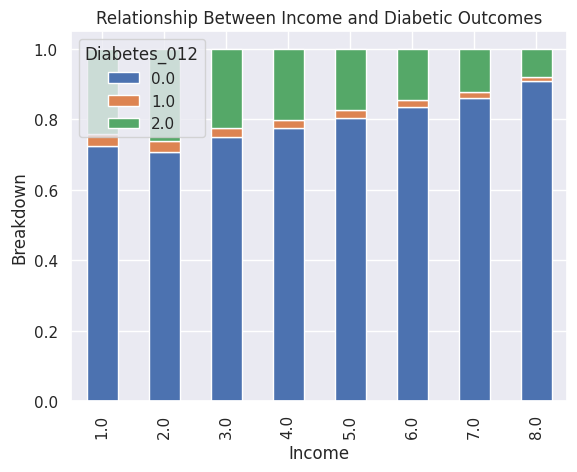

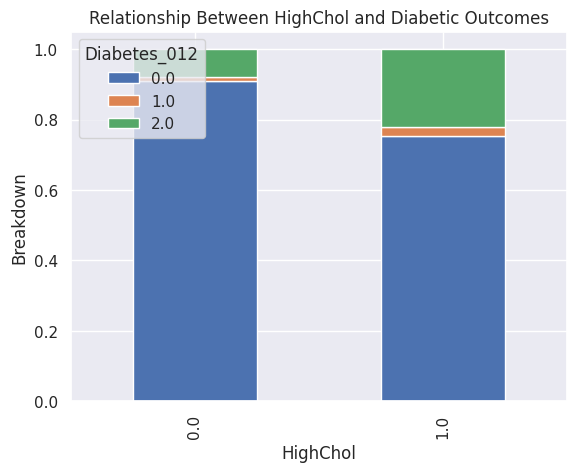

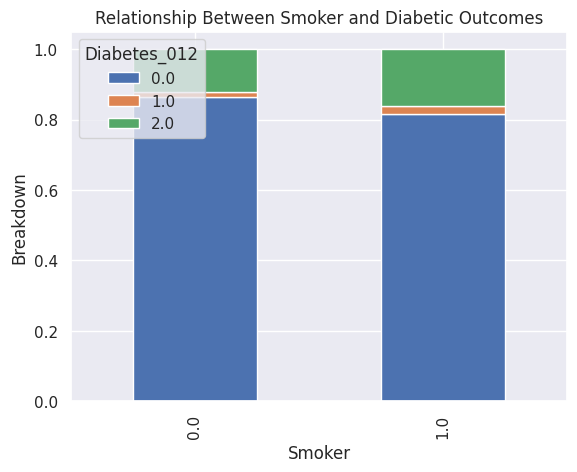

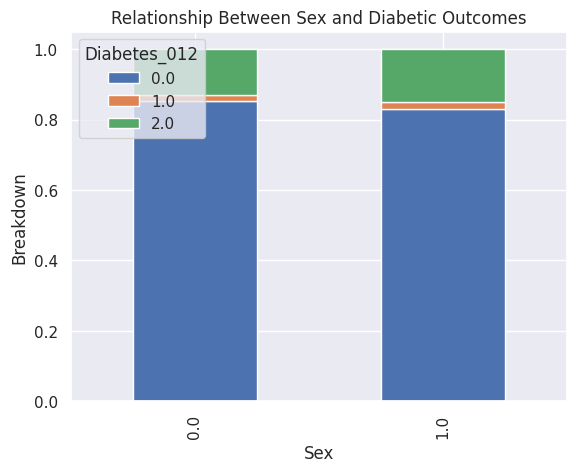

In [ ]:
# 3.2

# looks at the proportional relationship between HighBP, HighChol, and Income
categories = ['HighBP', 'Income', 'HighChol', 'Smoker', 'Sex']
for cat in categories:
    diabetes_data.groupby(cat)['Diabetes_012'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
    plt.title(f'Relationship Between {cat} and Diabetic Outcomes')
    plt.xlabel(cat)
    plt.ylabel('Breakdown')
    plt.legend(title='Diabetes_012', loc='upper left')
    plt.show()

These graphs display the proportional relationships of various health features and SDOH, such as income, sex, high blood pressure, etc. Lower income, high blood pressure and cholestoral seem to have the highest impact on diabetes diagnosis, with sex holding a smaller part.

Diabetes_012         1.000000
GenHlth              0.301443
HighBP               0.271596
BMI                  0.243112
DiffWalk             0.224239
                       ...   
HvyAlcoholConsump   -0.057882
Veggies             -0.058972
PhysActivity        -0.121947
Education           -0.130517
Income              -0.171483
Name: Diabetes_012, Length: 22, dtype: float64


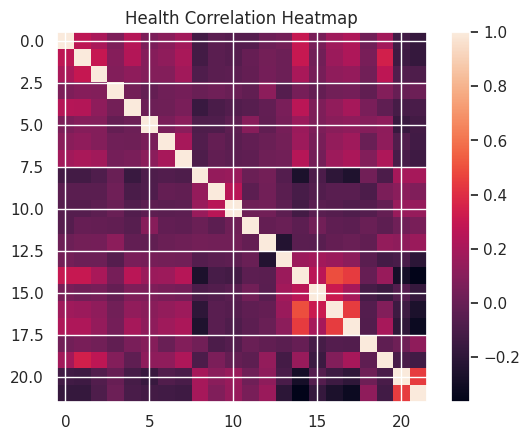

In [ ]:
# 3.3

# finds correlation between features
correlation_matrix = diabetes_data.corr()

print(correlation_matrix['Diabetes_012'].sort_values(ascending=False))

# heatmap based on correlation

plt.imshow(correlation_matrix)
plt.colorbar()
plt.title('Health Correlation Heatmap')

plt.show()

This correlation heatmap displays that general health, high BP and high BMI seem to have the highest correlation rate with diabetes, though it is not a high rate at between 20-30%.

# Question 4 — (20 points) - Audrey
Perform significance tests to determine if the patterns that are detected above are statistically significant. Ensure that you discuss at least three patterns and the respective p-values.
Select the features that will be used in the ML models (i.e. your selected features should be based on analytical reasoning that demonstrates their utility for ML modeling. Do not arbitrarily select features.
Note: if you are using correlations, ensure that this is only performed using continuous variables.

In [ ]:
# 4.1

# Statistical significance testing

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Remvoing target from categorical columns
cat_col = [col for col in cat_col if col != 'Diabetes_012']

# Chi-squared test for categorical variables
chi2_results = {}
for feature in cat_col:
    contingency_table = pd.crosstab(diabetes_data[feature], diabetes_data['Diabetes_012'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[feature] = p

# Display chi-squared results
chi2_results_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'P-Value'])
chi2_results_df = chi2_results_df.sort_values(by='P-Value', ascending=True)

print("Significance of Categorical Features (Chi-Squared Test)")
print(chi2_results_df)

# ANOVA for continuous variables
anova_results = {}
for feature in contin_col:
    groups = [diabetes_data[diabetes_data['Diabetes_012'] == group][feature].dropna() for group in diabetes_data['Diabetes_012'].unique()]
    f_stat, p = f_oneway(*groups)
    anova_results[feature] = p

# Display ANOVA results
anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'P-Value'])
anova_results_df = anova_results_df.sort_values(by='P-Value', ascending=True)
print("\nANOVA Results for Continuous Variables:")
print(anova_results_df)

Significance of Categorical Features (Chi-Squared Test)
                 Feature        P-Value
0                 HighBP   0.000000e+00
1               HighChol   0.000000e+00
5   HeartDiseaseorAttack   0.000000e+00
4                 Stroke   0.000000e+00
6           PhysActivity   0.000000e+00
..                   ...            ...
9      HvyAlcoholConsump  2.261930e-185
7                 Fruits   2.186703e-99
11           NoDocbcCost   9.815790e-87
13                   Sex   3.376679e-55
10         AnyHealthcare   9.997881e-16

[16 rows x 2 columns]

ANOVA Results for Continuous Variables:
    Feature        P-Value
0       BMI   0.000000e+00
2  PhysHlth   0.000000e+00
3   GenHlth   0.000000e+00
1  MentHlth  1.267200e-154


The Chi-Square test reveal that categorical features like HighBP, HighChol, Stroke, HeartDiseaseorAttack, and PhysActivity are significant in respect to our target diabetes_012. The ANOVA test reveals that continuous features like BMI, PhysHlth, and GenHlth are significant.

In [ ]:
# 4.2

# Final feature list
final_cat_features = ['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity']
final_cont_features = ['BMI', 'PhysHlth', 'GenHlth']
final_features = final_cat_features + final_cont_features

X = diabetes_data[final_features]
X = pd.get_dummies(X, drop_first=True)
y = diabetes_data['Diabetes_012']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Top 5 Features by Importance:")
print(feature_importance.head(5))

Top 5 Features by Importance:
    Feature  Importance
5       BMI    0.343905
7   GenHlth    0.199126
0    HighBP    0.144967
6  PhysHlth    0.144669
1  HighChol    0.077923


By combining the results of our Chi-Square and ANOVA tests with the feature importance rankings from Random Forest, we see that BMI, GenHlth, HighBP, PhysHlth, and HighChol are the top 5 most important features and contribute significantly in relation to the target variable.

# Question 5 (5 pts) - Taha
Partition the data into train/test sets. After which, perform the following:
encode any categorical data. Ensure that categorical variables are represented correctly.
normalize numeric data.
Tip: Ensure that you use sklearn to normalize and/or encode the training data, after which transform the test set (there is an example in the lecture).


In [ ]:
#5

# Partition the data
X   = diabetes_data[['HighBP', 'BMI', 'GenHlth', 'PhysHlth']] # Get the input features
y   = diabetes_data['Diabetes_012']                           # Get the target

X_train, X_test, y_train, y_test = train_test_split(X,              # The input features
                                                    y,              # The label
                                                    test_size=0.1,  # Set aside 10% of the data as the test set
                                                    random_state=7, # Reproduce the results
                                                    stratify=y      # Preserve the distribution of the labels
                                                   )

X_train = X_train.copy()
X_test  = X_test.copy()

# Encode the categorical feature
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Drop one of the encoded categorical columns
encoder.fit(X_train[['HighBP']])

# Normalize the numeric features
scaler = StandardScaler()
scaler.fit(X_train[['BMI', 'PhysHlth', 'GenHlth']])

X_train[['BMI', 'PhysHlth', 'GenHlth']] = scaler.transform(X_train[['BMI', 'PhysHlth', 'GenHlth']]) # Scale the training data

# View the prepared data
X_train.head(10)

,HighBP,BMI,GenHlth,PhysHlth
240934,0.0,0.519027,-0.479966,-0.641288
68048,1.0,-1.458377,-0.479966,-0.641288
78095,0.0,-0.379793,-0.479966,-0.641288
198977,1.0,1.957139,1.485631,1.090765
17450,0.0,-0.559557,-1.462764,-0.641288
244618,0.0,-1.817905,-0.479966,-0.641288
233184,1.0,-1.098849,0.502832,-0.641288
75573,0.0,-0.919085,-0.479966,1.956791
227949,1.0,0.698791,0.502832,0.397944
77303,0.0,0.339263,0.502832,0.051533


# Question 6 (30 pts) - Taha
Build the ML model that predicts the target variable based on the selected features. Ensure that you:
Demonstrate the training, evaluation and tuning for at least three algorithms that can handle non linear data and multiple input features/variables. NOTE: you can only select one tree-based algorithm and you must select multiple input features for the ML modeling.
Use GridSearchCV to tune at least two hyperparameters for each algorithm.
Note: do not change the input features in your experiments.

In [ ]:
# 6.1

# Initialize the classifier
svm = SVC(kernel='linear', C=1, max_iter=150) # The default kernel is rbf
svm.fit(X_train, y_train) # Fit the data

# Encode & scale the new/test data
X_test['HighBP']             = encoder.transform(X_test[['HighBP']]) # Encode the test data
X_test[['BMI', 'PhysHlth', 'GenHlth']] = scaler.transform(X_test[['BMI', 'PhysHlth', 'GenHlth']]) # Scale the test data

# Predict the labels for the test set
y_pred   = svm.predict(X_test)

print('The predicted Diabetes_binary is: {}'.format(y_pred))

# Evaluate the prediction accuracy
print('The accuracy of the model is: {}'.format(svm.score(X_test, y_test)))

# Get the classification report
target_names = ['Diabetes_0', 'Diabetes_1', 'Diabetes_2']
print(classification_report(y_test, y_pred, target_names = target_names))

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The predicted Diabetes_binary is: [0. 2. 0. ... 2. 0. 0.]
The accuracy of the model is: 0.7843345947650583
              precision    recall  f1-score   support

  Diabetes_0       0.88      0.87      0.88     21370
  Diabetes_1       0.04      0.03      0.03       463
  Diabetes_2       0.32      0.34      0.33      3535

    accuracy                           0.78     25368
   macro avg       0.41      0.42      0.41     25368
weighted avg       0.79      0.78      0.78     25368



In [ ]:
# 6.2

# Setup the parameter grid to try values of c ranging from 1 to 10, and values for gamma ranging from 1 to 5.
params = {'C': np.arange(1, 10),
         'gamma': np.arange(1, 5)}

In [ ]:
6.3

# Initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5, return_train_score = True)
svm_grid.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-

GridSearchCV(cv=5, estimator=SVC(C=1, kernel='linear', max_iter=150),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': array([1, 2, 3, 4])},
             return_train_score=True)

In [ ]:
# 6.4

print(svm_grid.best_params_) # Print the best parameters
print(svm_grid.best_score_)  # Print the best score

{'C': np.int64(5), 'gamma': np.int64(1)}
0.63760150169709


#Question 7 (15 pts) - Nikita
Analyze the evaluated models. For each algorithm, ensure that you:
Display: 1) the best model and 2) the best score that was obtained.
Evaluate the scores from GridSearchCV for the training set and the test set to diagnose any bias-variance problems. Comment on the quality of the model.
NOTE: seeing that you are analyzing healthcare data, ensure that you discuss what is the desired metric to evaluate the results based on the machine learning task e.g. accuracy, precision, recall, f1-score, MSE, R2, etc.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# Load and preprocess data (replace 'your_dataset.csv' with your actual file)
file_path = 'diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_data = pd.read_csv(file_path)

# Define categorical and continuous columns
cat_col = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
           'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
           'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk',
           'Sex', 'Education', 'Income']
contin_col = ['BMI', 'MentHlth', 'PhysHlth', 'GenHlth']

# Remove missing values
diabetes_data.dropna(inplace=True)

# Split data into features and target
X = diabetes_data[cat_col + contin_col]
y = diabetes_data['Diabetes_012']

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models and parameter grids
models = {
    "RandomForest": {
        "model": RandomForestClassifier(max_depth=15, random_state=42),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [10, 20, None], "min_samples_split": [2, 5]},
    },
    "SVM": {
        "Model": SVC(kernel='linear', C=1, max_iter=150, random_state=42),
        "params": {"C": [0.1, 1], "kernel": ["linear", "rbf"]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]},
    },
}

# Perform GridSearchCV for each model
results = {}
for name, config in models.items():
    grid_search = GridSearchCV(
        config["model"], config["params"], cv=5, scoring="f1_macro", return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    results[name] = {
        "best_model": best_model,
        "best_score": best_score,
        "train_f1": f1_score(y_train, y_train_pred, average="macro"),
        "test_f1": f1_score(y_test, y_test_pred, average="macro"),
        "precision": precision_score(y_test, y_test_pred, average="macro"),
        "recall": recall_score(y_test, y_test_pred, average="macro"),
        "accuracy": accuracy_score(y_test, y_test_pred),
        "classification_report": classification_report(y_test, y_test_pred),
    }

# Display results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Model: {result['best_model']}")
    print(f"Best Cross-Validation Score (F1 Macro): {result['best_score']:.2f}")
    print(f"Training F1 Score: {result['train_f1']:.2f}")
    print(f"Test F1 Score: {result['test_f1']:.2f}")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result["classification_report"])
    print("=" * 50)


KeyboardInterrupt: 

# Question 8 (5 pts) - Nikita
Discuss the potential impacts of your solution. Who will benefit from (and/or who will be affected by) your solution and why.
Were there any concerns of bias in the ML modeling seeing that you were analyzing sensitive data? Create visualizations to share any analysis of bias in the training data and/or the predictions from the model. For example: you can compare and contrast the predictions for specific groups to demonstrate your findings. Provide recommendations on techniques to address any issues that were found.
Note: you are welcome to use libraries to perform the analysis.

In [ ]:
# 8

# Example to simulate group-specific bias analysis (replace 'diabetes_data' with actual data)
# Assuming 'diabetes_data' contains demographic information like 'Income', 'Sex', etc.

# Simulate predictions and demographic data (replace with actual model predictions)
# Example demographics
demographics = pd.DataFrame({
    'Income': np.random.choice(['Low', 'Medium', 'High'], size=100),
    'Sex': np.random.choice(['Male', 'Female'], size=100),
    'Actual': np.random.choice([0, 1, 2], size=100),  # Actual diabetic status
    'Predicted': np.random.choice([0, 1, 2], size=100)  # Predicted diabetic status
})

# Bias analysis for groups
group_metrics = demographics.groupby('Income').apply(
    lambda df: pd.Series({
        'Accuracy': accuracy_score(df['Actual'], df['Predicted']),
        'Precision': precision_score(df['Actual'], df['Predicted'], average='macro', zero_division=1),
        'Recall': recall_score(df['Actual'], df['Predicted'], average='macro', zero_division=1),
        'F1': f1_score(df['Actual'], df['Predicted'], average='macro', zero_division=1),
    })
)

# Plot the results
plt.figure(figsize=(10, 6))
group_metrics.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Across Income Groups")
plt.ylabel("Scores")
plt.xlabel("Income Groups")
plt.legend(title="Metric")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Recommendations for addressing bias
recommendations = """
1. **Rebalancing Dataset:** Ensure equal representation of demographic groups during model training.
2. **Fairness-aware Algorithms:** Implement algorithms designed to minimize demographic-based disparities.
3. **Post-processing Adjustments:** Adjust thresholds for specific groups to equalize outcomes.
4. **Continuous Monitoring:** Regularly analyze predictions to ensure fairness in real-world applications.
"""

print("Bias Mitigation Recommendations:")
print(recommendations)
